In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from interpret.glassbox import ExplainableBoostingRegressor as EBR
from scipy.stats import ttest_ind
# https://www.collegehockeynews.com/stats/?season=20212022

# Basic story: With fans, more shot attempts but they are low-quality shot attempts. No impact on goals (if any, a decrease in goals).
# Big increase in penalty minutes / game with fans.
years = ["2018_2019", "2019_2020", "2020_2021", "2021_2022"]

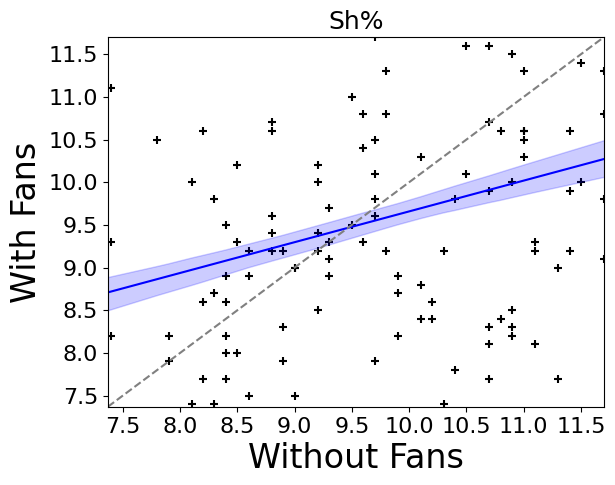

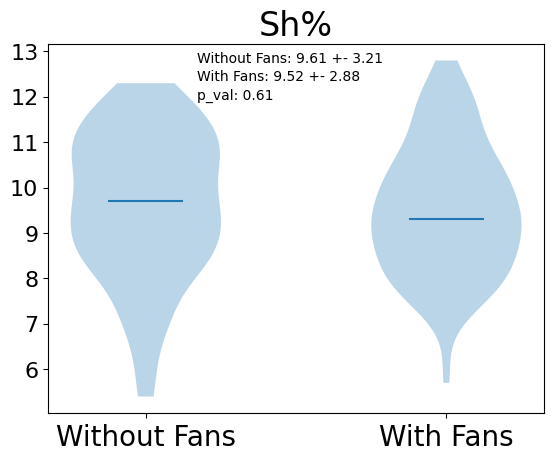

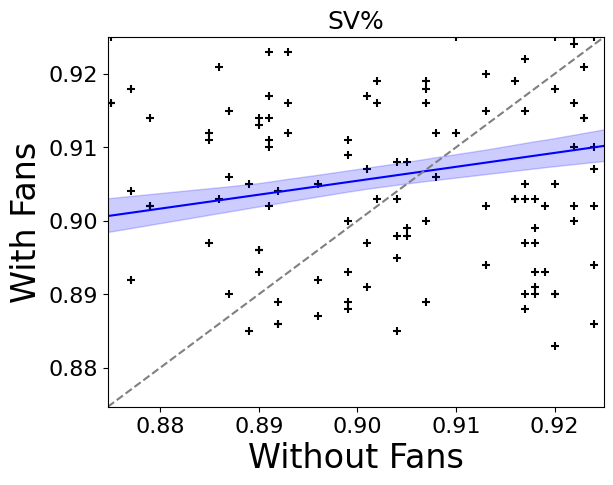

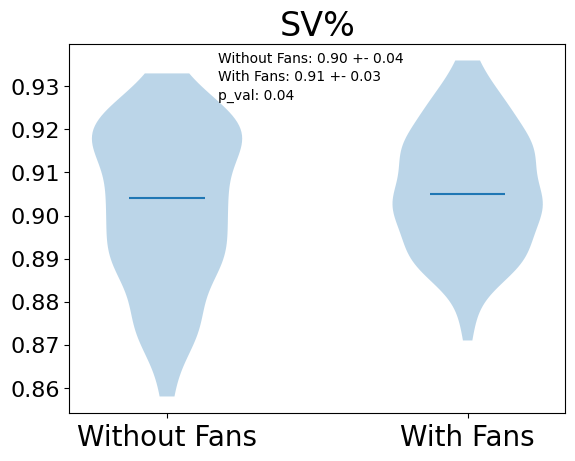

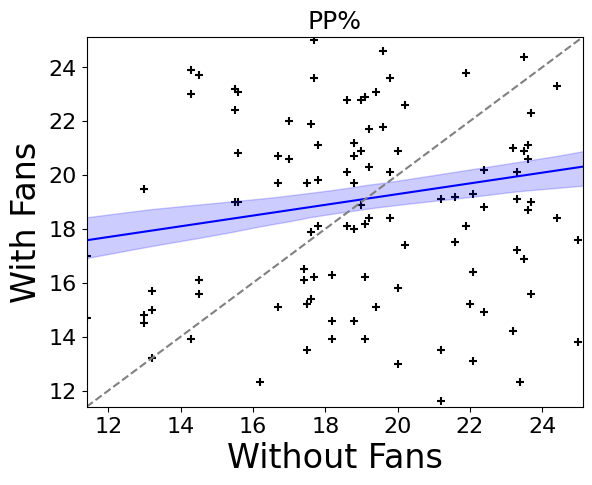

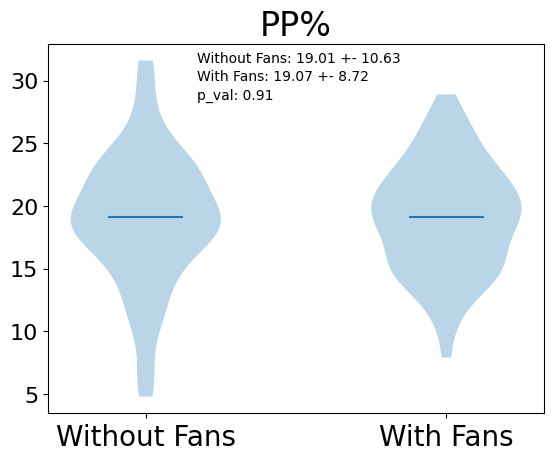

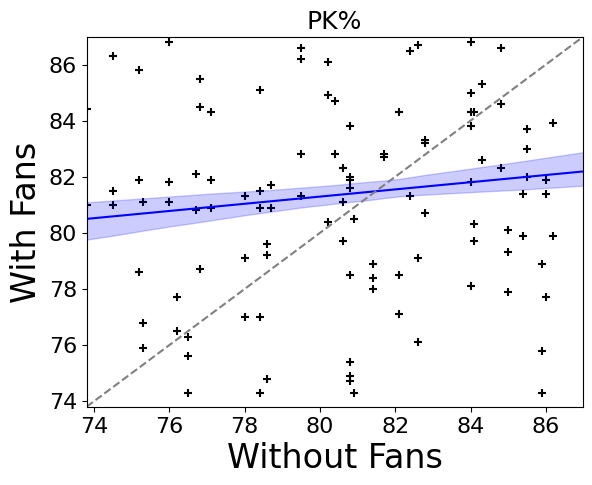

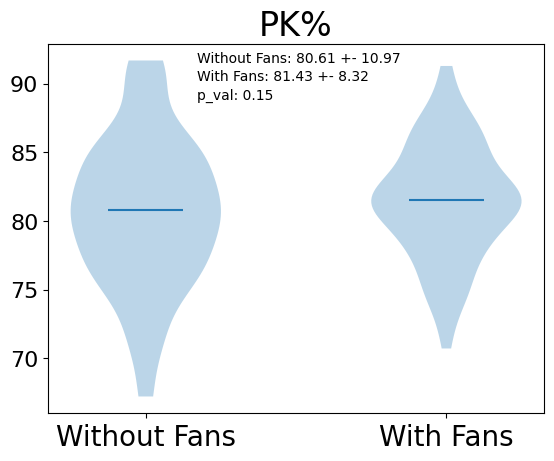

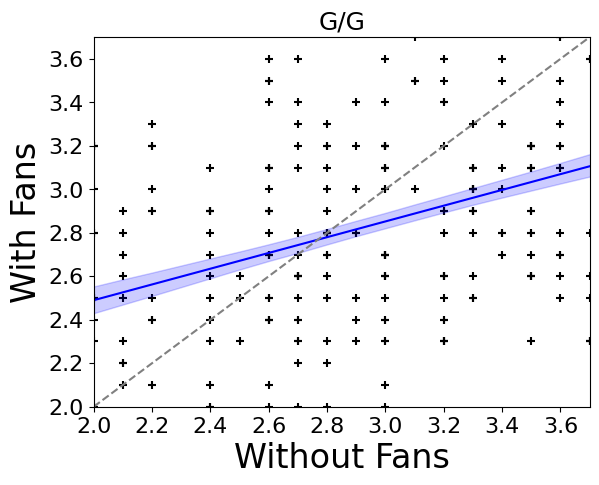

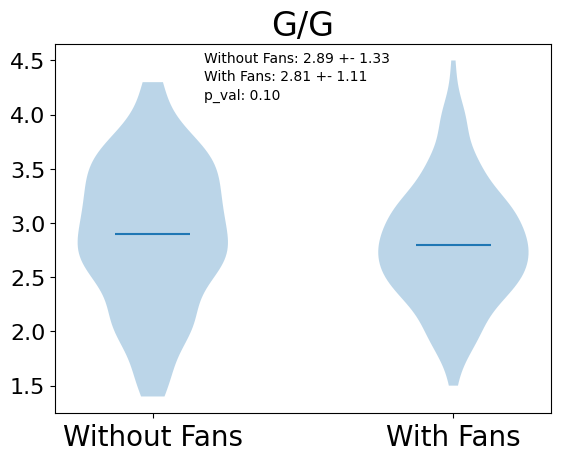

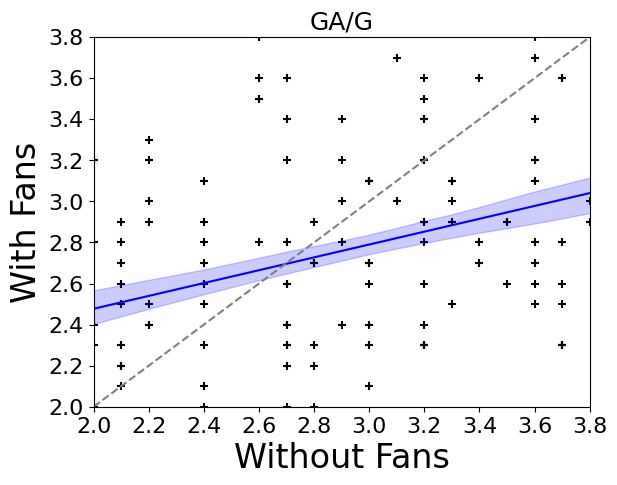

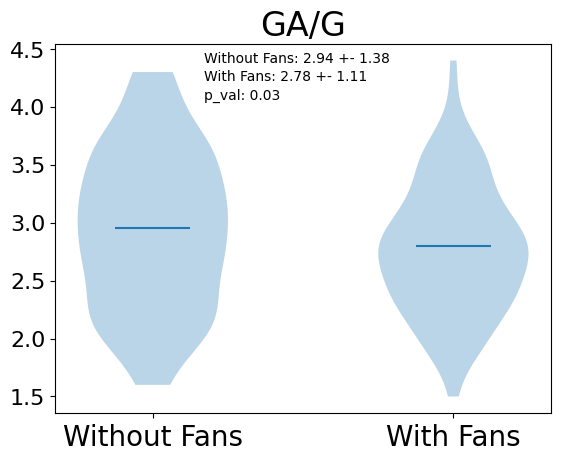

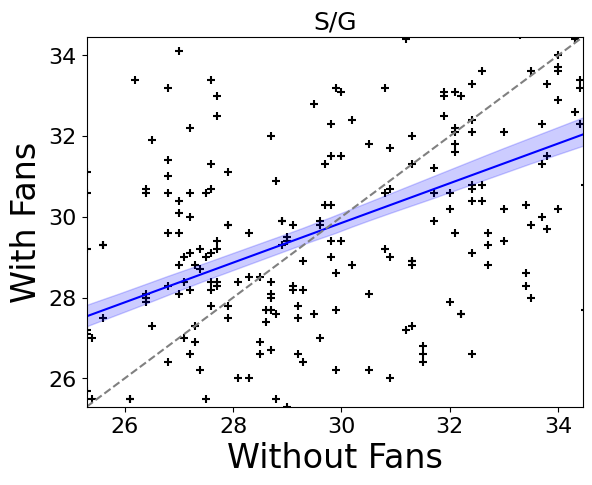

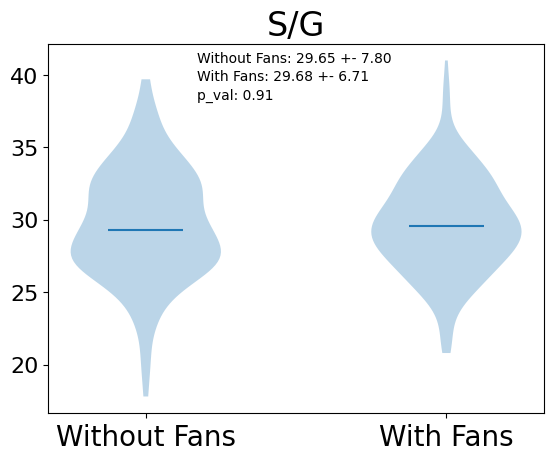

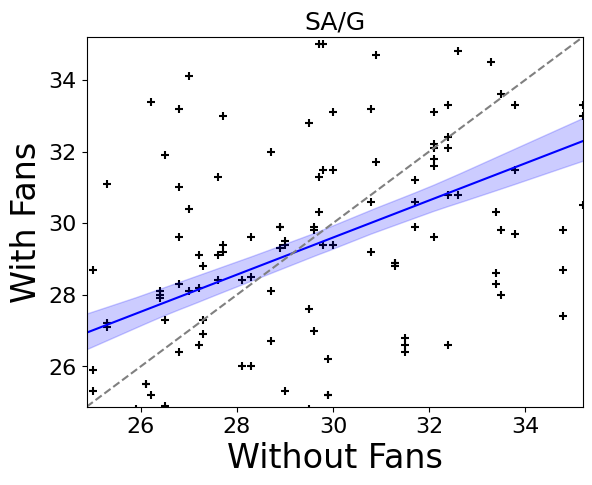

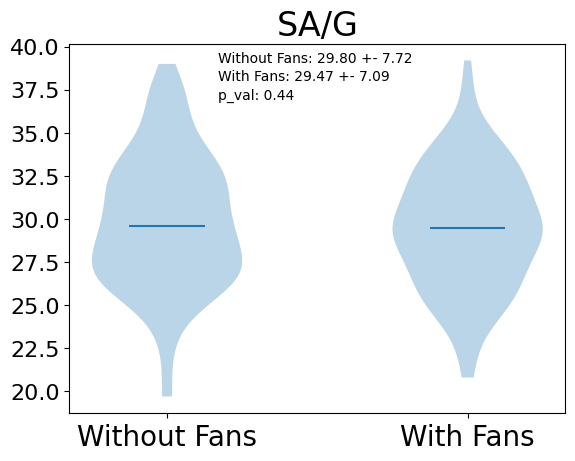

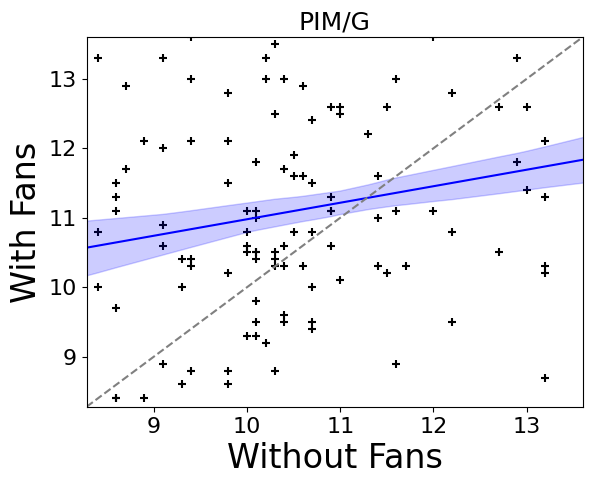

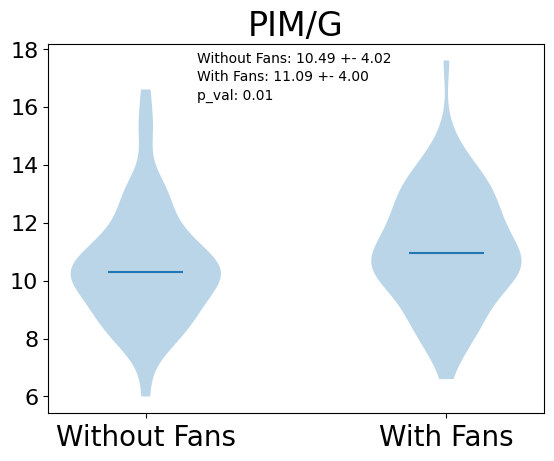

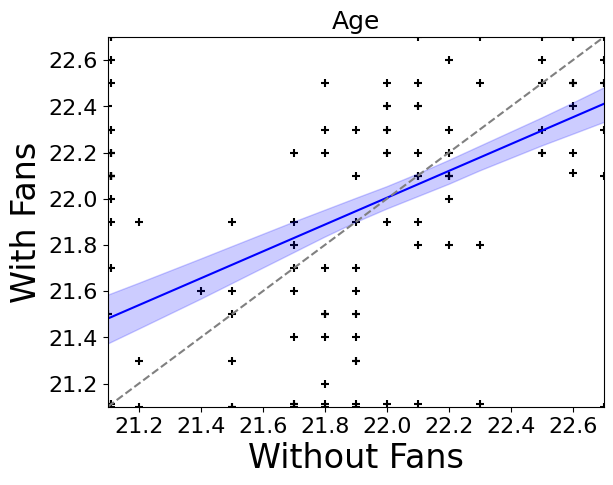

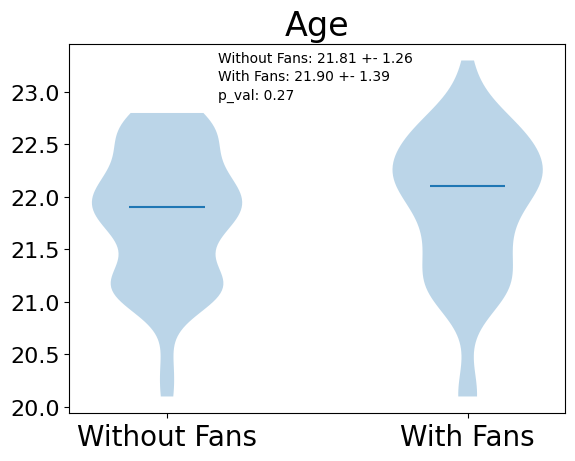

In [2]:
def get_df_for_year(year):
    return pd.read_csv(f"data/{year}.csv", sep=',', header=0)
dfs_by_year = {year: get_df_for_year(year) for year in years}

results_by_team = {}
covid_teams = dfs_by_year["2020_2021"]["Team"].values
for team in covid_teams:
    results_by_team[team] = {year: dfs_by_year[year].loc[dfs_by_year[year]["Team"] == team] for year in years}

for attribute in dfs_by_year["2020_2021"].columns:
    if attribute in ['Rk', "Team", "GP", "G", "GA", "Sh", "ShA", "SHG", "SHGA", "Ht", "Wt", "PIM", "FO%"]:
        continue
    fig = plt.figure()
    xs = []
    ys = []
    def gather_xs_ys(attribute):
        for year in years:
            if year == "2020_2021":
                continue
            for team in covid_teams:
                try:
                    plt.scatter(
                        results_by_team[team]["2020_2021"][attribute],
                        results_by_team[team][year][attribute],
                        marker='+', color='black')
                    ys.append(results_by_team[team][year][attribute].values[0])
                    xs.append(results_by_team[team]["2020_2021"][attribute].values[0])
                except ValueError:
                    pass
    gather_xs_ys(attribute)
    if "/G" in attribute:
        try:
            gather_xs_ys(f"{attribute.split('/G')[0]}A/G")
        except KeyError:
            pass
    if "%" in attribute:
        try:
            gather_xs_ys(f"{attribute.split('%')[0]}A%")
        except KeyError:
            pass
    y_preds = []            
    order = np.argsort(xs)
    xs = np.array(xs)[order]
    ys = np.array(ys)[order]
    x_means = []
    y_means = []
    coefs = []
    intercepts = []
    for iteration in range(100):
        x_train, x_test, y_train, y_test = train_test_split(
            np.expand_dims(xs, 1), ys, shuffle=True, test_size=0.3)
        ebr = LinearRegression() #EBR(max_bins=128)
        ebr.fit(x_train, y_train)
        coefs.append(ebr.coef_[0])
        intercepts.append(ebr.intercept_)
        y_preds.append(ebr.predict(np.expand_dims(xs, 1)))
        x_means.append(np.mean(x_train))
        y_means.append(np.mean(y_train))
        
    y_preds = np.array(y_preds)
    plt.plot(xs, np.mean(y_preds, axis=0), color='blue')
    plt.fill_between(
        xs,
        np.percentile(y_preds, 2.5, axis=0),
        np.percentile(y_preds, 97.5, axis=0),
        color='blue', alpha=0.2)
    
    xlims = [np.percentile(xs, 10), np.percentile(xs, 90)]#plt.xlim()
    ylims = [np.percentile(ys, 10), np.percentile(ys, 90)]#plt.ylim()
    my_lims = [np.min([xlims[0], ylims[0]]), np.max([xlims[1], ylims[1]])]
    plt.plot(np.linspace(my_lims[0], my_lims[1], 100),
             np.linspace(my_lims[0], my_lims[1], 100),
             linestyle='--', color='gray')
    plt.xlim(my_lims)
    plt.ylim(my_lims)

    plt.ylabel("With Fans", fontsize=24)
    plt.xlabel("Without Fans", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(attribute, fontsize=18)
    
    fig = plt.figure()
    ax = plt.gca()
    ax.violinplot([xs, ys], showmedians=True, showextrema=False)
    plt.annotate(f"Without Fans: {np.mean(xs):.2f} +- {2*np.std(xs):.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.95))
    plt.annotate(f"With Fans: {np.mean(ys):.2f} +- {2*np.std(ys):.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.90))
    plt.annotate(f"p_val: {ttest_ind(xs, ys, equal_var=False).pvalue:.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.85))
    plt.xticks([1, 2], ["Without Fans", "With Fans"], fontsize=20)
    plt.yticks(fontsize=16)
    plt.title(attribute, fontsize=24)
    plt.show()

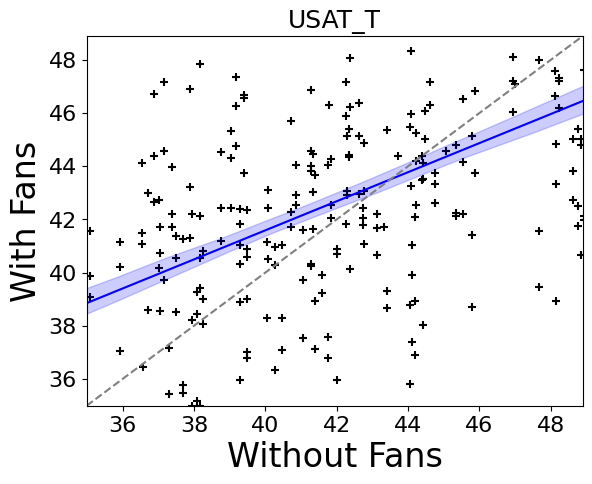

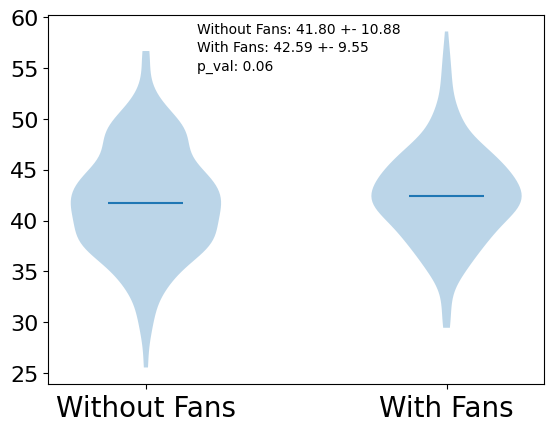

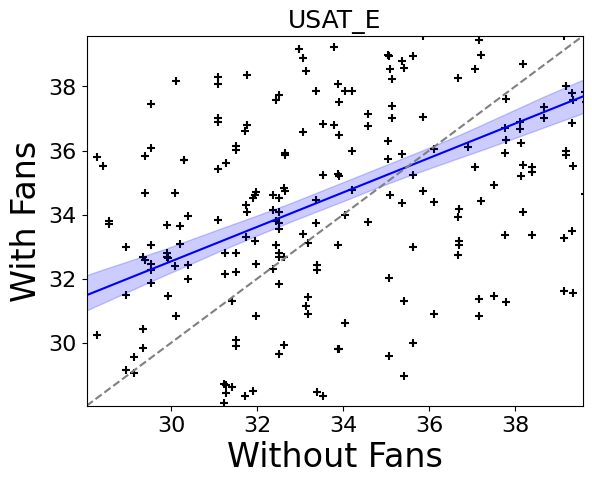

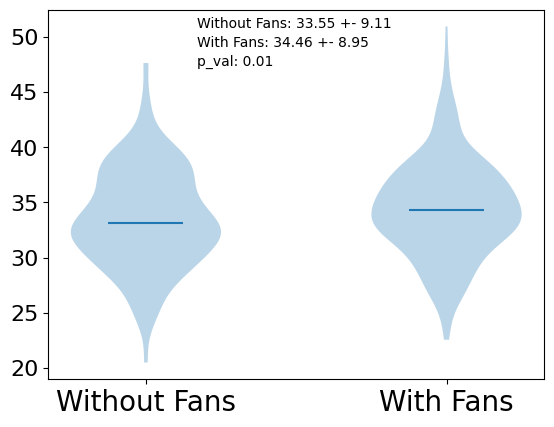

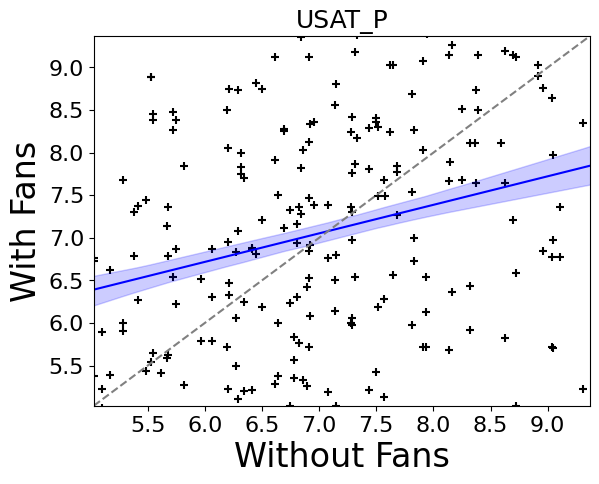

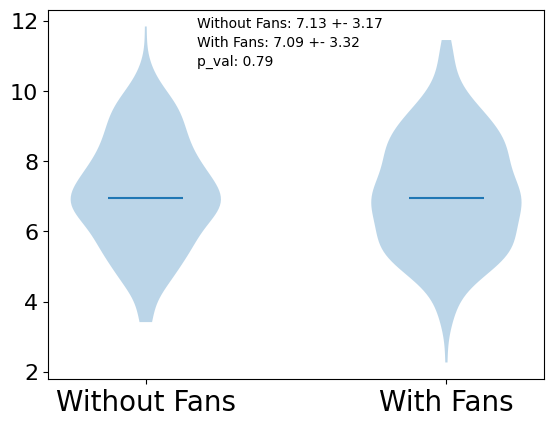

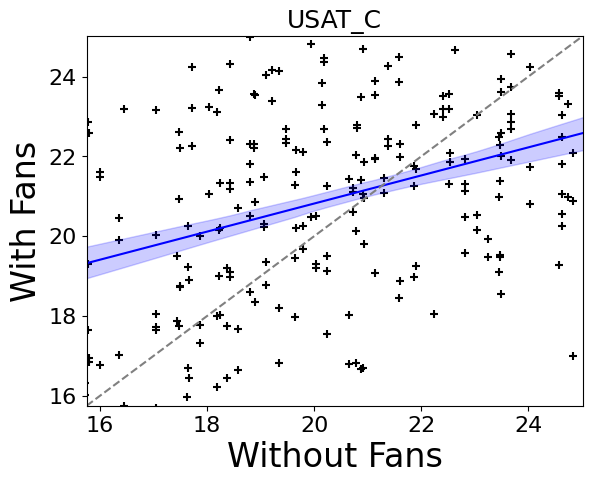

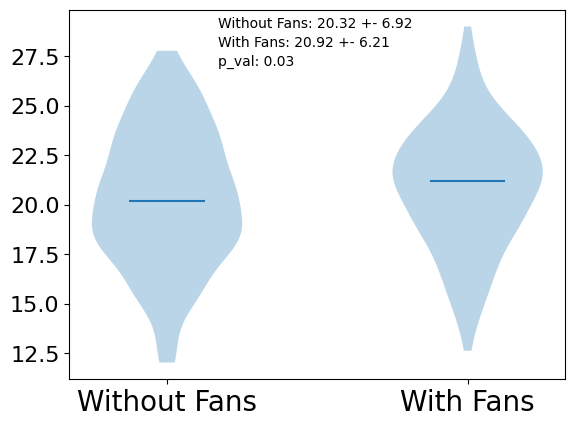

In [7]:
def get_adv_df_for_year(year):
    df = pd.read_csv(f"data/{year}_Adv.csv", sep=',', header=0).drop("Rk", inplace=False, axis=1)
    df['Team'] = df['Team'].astype(str)
    return df

adv_dfs_by_year = {year: get_adv_df_for_year(year) for year in years}

results_by_team = {}
covid_teams = adv_dfs_by_year["2020_2021"]["Team"].values
for team in covid_teams:
    results_by_team[team] = {year: adv_dfs_by_year[year].loc[adv_dfs_by_year[year]["Team"] == team] for year in years}

for attribute in adv_dfs_by_year["2020_2021"].columns:
    if attribute in ['Rk', "Team", "GP", "G", "GA", "Sh", "ShA", "SHG", "SHGA", "Ht", "Wt", "PIM"]:
        continue
    if "USAT_" not in attribute:
        continue
    fig = plt.figure()
    xs = []
    ys = []
    y_preds, x_preds = [], []
    def gather_xs_ys(attribute):
        for year in years:
            if year == "2020_2021":
                continue
            for team in covid_teams:
                try:    
                    my_y = results_by_team[team][year][attribute].values[0]
                    my_x = results_by_team[team]["2020_2021"][attribute].values[0]
                    if "USA" in attribute:
                        my_y /= results_by_team[team][year]["GP"].values[0]
                        my_x /= results_by_team[team]["2020_2021"]["GP"].values[0]
                    plt.scatter(my_x, my_y, marker='+', color='black')
                    xs.append(my_x)
                    ys.append(my_y)
                except IndexError:
                    pass
    gather_xs_ys(attribute)
    if "_" in attribute:
        try:
            gather_xs_ys(f"{attribute.split('_')[0]}A_{attribute.split('_')[1]}")
        except KeyError:
            pass
    order = np.argsort(xs)
    xs = np.array(xs)[order]
    ys = np.array(ys)[order]
    for iteration in range(100):
        x_train, x_test, y_train, y_test = train_test_split(
            np.expand_dims(xs, 1), ys, shuffle=True, test_size=0.3)
        ebr = LinearRegression() #EBR(max_bins=128, min_samples_leaf=2)
        ebr.fit(x_train, y_train)
        y_preds.append(ebr.predict(np.expand_dims(xs, 1)))
        """
        ebr = EBR(max_bins=128)
        ebr.fit(np.expand_dims(y_train, 1), x_train)
        x_preds.append(ebr.predict(np.expand_dims(ys, 1)))
        """
        
    y_preds = np.array(y_preds)
    plt.plot(xs, np.mean(y_preds, axis=0), color='blue')
    plt.fill_between(
        xs,
        np.percentile(y_preds, 2.5, axis=0),
        np.percentile(y_preds, 97.5, axis=0),
        color='blue', alpha=0.2)
    
    """
    x_preds = np.array(x_preds)
    x_preds_order = np.argsort(np.mean(x_preds, axis=0))
    plt.plot(np.mean(x_preds, axis=0)[x_preds_order], ys[x_preds_order], color='red')
    plt.fill_between(
        x_preds,
        np.percentile(y_preds, 2.5, axis=0),
        np.percentile(y_preds, 97.5, axis=0),
        color='red', alpha=0.2)
    """
            
    xlims = [np.percentile(xs, 10), np.percentile(xs, 90)]#plt.xlim()
    ylims = [np.percentile(ys, 10), np.percentile(ys, 90)]#plt.ylim()
    my_lims = [np.min([xlims[0], ylims[0]]), np.max([xlims[1], ylims[1]])]
    plt.plot(np.linspace(my_lims[0], my_lims[1], 100),
             np.linspace(my_lims[0], my_lims[1], 100),
             linestyle='--', color='gray')
    plt.xlim(my_lims)
    plt.ylim(my_lims)
    plt.ylabel("With Fans", fontsize=24)
    plt.xlabel("Without Fans", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(attribute, fontsize=18)
    plt.show()
    
    fig = plt.figure()
    ax = plt.gca()
    ax.violinplot([xs, ys], showmedians=True, showextrema=False)
    plt.annotate(f"Without Fans: {np.mean(xs):.2f} +- {2*np.std(xs):.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.95))
    plt.annotate(f"With Fans: {np.mean(ys):.2f} +- {2*np.std(ys):.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.90))
    plt.annotate(f"p_val: {ttest_ind(xs, ys, equal_var=False).pvalue:.2f}", (plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.3, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])*0.85))
    plt.xticks([1, 2], ["Without Fans", "With Fans"], fontsize=20)
    plt.yticks(fontsize=16)
    #plt.title(attribute, fontsize=24)
    plt.show()